# Adversarial Training and Overall Evaluation
*Author: Areeb Gani*

## Installing Packages and Imports

This notebook walks through an adversarial training pipeline for DINOv2. Much of the adversarial training code is based off our written homework, but modified to account for structure of the DINOv2 model.

In [ ]:
# Installing packages
!pip install lightning transformers datasets dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 54.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
from torchmetrics import Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from transformers import AutoModelForImageClassification, AutoImageProcessor
from datasets import load_dataset
from tqdm import tqdm

from datasets import VerificationMode
from dotenv import load_dotenv

load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

## Configuration and Setup

Here we define the device, along with several parameters for our training. Note that the `adv_train_unfreeze_4` is an adversarially trained model with the last 4 blocks unfreezed, while the `adv_train` is an adversarially trained model with everything unfreezed.

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

NUM_CLASSES = 1000

cuda:0


In [ ]:
# If you run into memory issues, you can reduce the batch size
BATCH_SIZE = 32  # Reduced from 128 for larger images

# Dataset and model configuration
DATASET_NAME = "ILSVRC/imagenet-1k"
MODEL_NAME = "facebook/dinov2-small-imagenet1k-1-layer"

# Paths for data and model checkpoints
DATA_PATH = 'data/'
CHECKPOINT_PATH = 'models/checkpoints/'

# The different models we'll be training
SAVE_NAMES = [
    'baseline',
    'adv_train_unfreeze_4',
    'adv_train',
]
SAVE_NAMES = {
    name: os.path.join(CHECKPOINT_PATH, name) for name in SAVE_NAMES
}

In [5]:
models = {name: None for name in SAVE_NAMES.keys()}
attacks = {
    'id': None,
    'fgsm': None,
    'pgd': None,
}

results_dic = {
    'model': [],
    'attack': [],
    'top_k': [],
    'accuracy': [],
}
results_trainer = L.Trainer(accelerator='auto', devices=1)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


## Data

Here we load the processor for our model, along with the ImageNet dataset. While in the full training run we load the ImageNet data, for reproducibility checks, we can also load a subset of the data files to run within a reasonable amount of time. For the `get_imagenet_loaders` function below, setting the parameter `data_files=False` will load all of the data; while leaving it as is will only retain a subset.

In [6]:
# Load DINOv2 image processor for proper normalization
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# For testing purposes, not going to load all of ImageNet, so you can load the following data files below to get a shorter version!
data_files = {
    "train": ["data/train-0000{}-of-00294.parquet".format(i) for i in range(10)] + ["data/train-000{}-of-00294.parquet".format(i) for i in range(10, 20)],
    "test": ["data/test-0000{}-of-00028.parquet".format(i) for i in range(5)],
    "validation": ["data/validation-0000{}-of-00014.parquet".format(i) for i in range(8)]
}

def get_imagenet_loaders(batch_size, data_files=data_files):
    """Load ImageNet-1k dataset from HuggingFace."""

    # Load dataset
    print(f"Loading dataset: {DATASET_NAME}")

    if data_files:
        dataset = load_dataset(DATASET_NAME, verification_mode=VerificationMode.NO_CHECKS, data_files=data_files, token=HF_TOKEN)
    else:
        dataset = load_dataset(DATASET_NAME, token=HF_TOKEN)

    trainset = dataset["train"]
    valset = dataset["validation"]
    testset = dataset["test"]

    print(f"Train size: {len(trainset):,}")
    print(f"Val size: {len(valset):,}")

    # Preprocessing function using DINOv2 processor
    def preprocess(examples):
        # Process images - handles resizing and normalization for DINOv2
        # print("Available keys in examples:", examples.keys()) # Added for debugging
        images = examples['image']
        labels = examples['label']

        processed = processor(images=images, return_tensors="pt", size={"height": 224, "width": 224})
        processed['labels'] = torch.tensor(labels)

        return processed

    # Collate function for DataLoader
    def collate_fn(batch):
        images = torch.stack([item['pixel_values'] for item in batch])
        labels = torch.tensor([item['labels'] for item in batch])
        return images, labels

    # Set transform
    trainset.set_transform(preprocess)
    valset.set_transform(preprocess)
    testset.set_transform(preprocess)

    # Create DataLoaders
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn, pin_memory=True
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True
    )


    return trainloader, valloader, testloader

In [9]:
trainloader, valloader, testloader = get_imagenet_loaders(BATCH_SIZE)
sample_images, sample_labels = next(iter(trainloader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

Loading dataset: ILSVRC/imagenet-1k


README.md:   0%|          | 0.00/87.6k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

data/train-00000-of-00294.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

data/train-00001-of-00294.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

data/train-00002-of-00294.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00003-of-00294.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00004-of-00294.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00005-of-00294.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

data/train-00006-of-00294.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

data/train-00007-of-00294.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

data/train-00008-of-00294.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

data/train-00009-of-00294.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00010-of-00294.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

data/train-00011-of-00294.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

data/train-00012-of-00294.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

data/train-00013-of-00294.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

data/train-00014-of-00294.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00015-of-00294.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

data/train-00016-of-00294.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00017-of-00294.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

data/train-00018-of-00294.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

data/train-00019-of-00294.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

data/test-00000-of-00028.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

data/test-00001-of-00028.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

data/test-00002-of-00028.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

data/test-00003-of-00028.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/test-00004-of-00028.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

data/validation-00000-of-00014.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

data/validation-00001-of-00014.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/validation-00002-of-00014.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

data/validation-00003-of-00014.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/validation-00004-of-00014.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/validation-00005-of-00014.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/validation-00006-of-00014.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

data/validation-00007-of-00014.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1281167 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Train size: 87,160
Val size: 28,574


## DINOv2 Lightning Module

This is adapter from the earlier code, but now working with the DINOv2 structure. Additionally, note that we have several finetuning strategies that are available depending on the user's preference.

In [ ]:
class LDINOv2(L.LightningModule):
    def __init__(self, finetune_strategy='all'):
        super().__init__()
        # Set loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        # DINOv2 expects 224x224 images
        self.example_input_array = torch.zeros((1, 3, 224, 224), dtype=torch.float32)
        self.num_target_classes = NUM_CLASSES
        # Accuracy metric for training logs and testing evaluation
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_target_classes, top_k=1)
        # Adversarial generation method for training
        self.adv_train_method = None

        # Load pretrained DINOv2 model from HuggingFace
        print(f"Loading model: {MODEL_NAME}")
        self.model = AutoModelForImageClassification.from_pretrained(
            MODEL_NAME,
            num_labels=self.num_target_classes,
            ignore_mismatched_sizes=True  # Allow different number of classes
        )

        #print(self.model.fc.in_features, self.num_target_classes)

        if finetune_strategy == 'last_n_blocks':
            # Unfreeze last N transformer blocks + head
            n_blocks = 4

            # Freeze everything first
            for param in self.model.parameters():
                param.requires_grad = False

            # Unfreeze last n blocks
            total_blocks = len(self.model.dinov2.encoder.layer)
            for i in range(total_blocks - n_blocks, total_blocks):
                for param in self.model.dinov2.encoder.layer[i].parameters():
                    param.requires_grad = True

            # Unfreeze classifier
            for param in self.model.classifier.parameters():
                param.requires_grad = True

    def forward(self, imgs):
        # DINOv2 returns object with .logits attribute
        outputs = self.model(imgs)
        return outputs.logits

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-5, weight_decay=0.1)
        return [optimizer]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        if self.adv_train_method is not None:
            opt = self.optimizers()
            opt.zero_grad()
            # Change the images to adversarial examples
            # Note: pass self.model (not self) to attack function
            imgs = self.adv_train_method(self.model, imgs, labels)
            # adv_train_method sets the model to eval
            self.model.train()
            # Reset accumulated gradients from adversarial generation
            opt.zero_grad()
        # Once we have the correct training images,
        # we can use the usual Lightning forward pass
        outputs = self.forward(imgs)
        loss = self.loss_module(outputs, labels)
        acc = self.accuracy(outputs, labels)
        # Log accuracy and loss per-batch for Tensorboard
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        outputs = self.forward(imgs)
        loss = self.loss_module(outputs, labels)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        outputs = self.forward(imgs)
        acc = self.accuracy(outputs, labels)
        self.log("test_acc", acc, prog_bar=True)

## Adversarial Attacks

Here, we set the adversarial attacks. In our project, we use FGSM as it is much more time- and cost-efficient compared to PGD (however, PGD is stronger).

In [ ]:
# Used as a baseline
def id(model, imgs, labels):
    return imgs.detach()

def fgsm(model, imgs, labels):
    r"""
    Args:
        model (nn.Module): Model to attack, e.g. self.model in the LDINOv2 definition.
        imgs (Tensor): Tensor of images. Size (BATCH_SIZE, C, H, W). Normalized according to means, stds.
        labels (Tensor): Tensor of labels. Size (BATCH_SIZE,). Each element is an integer in [0, NUM_CLASSES).
    Returns:
        adv_imgs (Tensor): Adversarial images. Same dimensions and normalization as imgs. Detached.
            Each adversarial image in the batch is L_infinity distance at most eps away from the original image.
            Images generated by the Fast Gradient Sign Method (FGSM).
    """
    eps = 8/255 # Maximum perturbation
    model.eval()
    loss_to_use = nn.CrossEntropyLoss()

    adv_imgs = imgs.clone().detach().requires_grad_(True)
    out = model(adv_imgs)

    # Handle DINOv2 output format (returns object with .logits)
    if hasattr(out, 'logits'):
        out = out.logits

    loss = loss_to_use(out, labels)
    loss.backward()

    sign = adv_imgs.grad.sign()

    adv_imgs = adv_imgs + eps * sign

    return adv_imgs.detach()

def pgd(model, imgs, labels):
    r"""
    Args:
        model (nn.Module): Model to attack, e.g. self.model in the LDINOv2 definition.
        imgs (Tensor): Tensor of images. Size (BATCH_SIZE, C, H, W). Normalized according to means, stds.
        labels (Tensor): Tensor of labels. Size (BATCH_SIZE,). Each element is an integer in [0, NUM_CLASSES).
    Returns:
        adv_imgs (Tensor): Adversarial images. Same dimensions and normalization as imgs. Detached.
            Each adversarial image in the batch is L_infinity distance at most eps away from the original image.
            Images generated by the Projected Gradient Descent (PGD)
    """
    iters = 20 # Number of steps in PGD
    eps = 8/255 # Maximum perturbation
    alpha = 2/255 # Step size
    model.eval()
    loss_to_use = nn.CrossEntropyLoss()

    adv_imgs = imgs.clone().detach()

    for i in range(iters):
        adv_imgs.requires_grad_(True) # re-enable everytime, becuase we detach every iteration

        out = model(adv_imgs)

        # Handle DINOv2 output format (returns object with .logits)
        if hasattr(out, 'logits'):
            out = out.logits

        loss = loss_to_use(out, labels)

        model.zero_grad() # because we previously ran stuff...

        loss.backward()

        with torch.no_grad(): # don't include in our computation graph
            sign = adv_imgs.grad.sign()
            adv_imgs = adv_imgs.detach() + alpha * sign

            perturbation = torch.clamp(adv_imgs - imgs, min = -eps, max = eps)
            adv_imgs = imgs + perturbation

    return adv_imgs.detach()

attacks['id'] = id
attacks['fgsm'] = fgsm
attacks['pgd'] = pgd

## Training

Now we can officially run the training code. Note that our model already has the head for ImageNet, so there is no need to do further training for the baseline. I verified this empirically by allowing it to run, but early stopping activates immediately anyways; so we limit it to 1 epoch here, to essentially retain the original model.

In [11]:
save_key = 'baseline'
baseline_model = LDINOv2()
baseline_trainer = L.Trainer(
    default_root_dir = SAVE_NAMES[save_key],
    accelerator='auto',
    devices=1,
    max_epochs=1, # this is already trained on imagenet...
    callbacks=[
        ModelCheckpoint(
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch')
    ],
)

baseline_trainer.logger._log_graph = True
baseline_trainer.logger._default_hp_metric = None

# Train the model
baseline_trainer.fit(baseline_model, trainloader, valloader)

# Load best checkpoint after training
baseline_model = LDINOv2.load_from_checkpoint(
    baseline_trainer.checkpoint_callback.best_model_path
).to(device)

models[save_key] = baseline_model

Loading model: facebook/dinov2-small-imagenet1k-1-layer


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   ┃ Name        ┃ Type                         ┃ Params ┃ Mode  ┃  FLOPs ┃         In sizes ┃ Out sizes ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0 │ loss_module │ CrossEntropyLoss             │      0 │ train │      0 │                ? │         ? │
│ 1 │ accuracy    │ MulticlassAccuracy           │      0 │ train │      0 │                ? │         ? │
│ 2 │ model       │ Dinov2ForImageClassification │ 22.8 M │ eval  │ 12.2 B │ [1, 3, 224, 224] │         ? │
└───┴─────────────┴──────────────────────────────┴────────┴───────┴────────┴──────────────────┴───────────┘

Trainable params: 22.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.8 M                                                                                               
Total estimated model params size (MB): 91                                                                         
Modules in train mode: 2                                                                                           
Modules in eval mode: 226                                                                                          
Total FLOPs: 12.2 B

Output()

INFO: Metric val_loss improved. New best score: 0.942
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.942
INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Loading model: facebook/dinov2-small-imagenet1k-1-layer


Now we run the training code, this time unfreezing the last 4 blocks and using FGSM as the inner-max solver. Note that we have 7.9M trainable parameters out of 22.8M options.

In [12]:
save_key = 'adv_train_unfreeze_4'

unfreeze_4_trained_model = LDINOv2(finetune_strategy='last_n_blocks')
unfreeze_4_trained_model.adv_train_method = attacks['fgsm']

unfreeze_4_trainer = L.Trainer(
    default_root_dir = SAVE_NAMES[save_key],
    accelerator='auto',
    devices=1,
    max_epochs=30,
    callbacks=[
        ModelCheckpoint(
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch')
    ],
)

unfreeze_4_trainer.logger._log_graph = True
unfreeze_4_trainer.logger._default_hp_metric = None

# Train the model
unfreeze_4_trainer.fit(unfreeze_4_trained_model, trainloader, valloader)

# Load best checkpoint after training
unfreeze_4_trained_model = LDINOv2.load_from_checkpoint(
    unfreeze_4_trainer.checkpoint_callback.best_model_path
).to(device)

models[save_key] = unfreeze_4_trained_model

Loading model: facebook/dinov2-small-imagenet1k-1-layer


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/91.3M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly uti

┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   ┃ Name        ┃ Type                         ┃ Params ┃ Mode  ┃  FLOPs ┃         In sizes ┃ Out sizes ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0 │ loss_module │ CrossEntropyLoss             │      0 │ train │      0 │                ? │         ? │
│ 1 │ accuracy    │ MulticlassAccuracy           │      0 │ train │      0 │                ? │         ? │
│ 2 │ model       │ Dinov2ForImageClassification │ 22.8 M │ eval  │ 12.2 B │ [1, 3, 224, 224] │         ? │
└───┴─────────────┴──────────────────────────────┴────────┴───────┴────────┴──────────────────┴───────────┘

Trainable params: 7.9 M                                                                                            
Non-trainable params: 15.0 M                                                                                       
Total params: 22.8 M                                                                                               
Total estimated model params size (MB): 91                                                                         
Modules in train mode: 2                                                                                           
Modules in eval mode: 226                                                                                          
Total FLOPs: 12.2 B

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.12/dist-packages/transformers/models/dinov2/modeling_dinov2.py:143: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:


Output()

INFO: Metric val_loss improved. New best score: 1.527
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1.527
INFO: Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 1.443
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 1.443
INFO: Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.415
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.415
INFO: Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.369
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.369
INFO: Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.357
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.357
INFO: Metric val_loss impr

Loading model: facebook/dinov2-small-imagenet1k-1-layer


And finally, we perform full adversarial training on the entire model. Again, we use FGSM as the inner-max solver.

In [14]:
save_key = 'adv_train'

adv_trained_model = LDINOv2()
adv_trained_model.adv_train_method = attacks['fgsm']

adv_trainer = L.Trainer(
    default_root_dir = SAVE_NAMES[save_key],
    accelerator='auto',
    devices=1,
    max_epochs=30,
    callbacks=[
        ModelCheckpoint(
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch')
    ],
)

adv_trainer.logger._log_graph = True
adv_trainer.logger._default_hp_metric = None

# Train the model
adv_trainer.fit(adv_trained_model, trainloader, valloader)

# Load best checkpoint after training
adv_trained_model = LDINOv2.load_from_checkpoint(
    adv_trainer.checkpoint_callback.best_model_path
).to(device)

models[save_key] = adv_trained_model

Loading model: facebook/dinov2-small-imagenet1k-1-layer


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/models/checkpoints/adv_train exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   ┃ Name        ┃ Type                         ┃ Params ┃ Mode  ┃  FLOPs ┃         In sizes ┃ Out sizes ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0 │ loss_module │ CrossEntropyLoss             │      0 │ train │      0 │                ? │         ? │
│ 1 │ accuracy    │ MulticlassAccuracy           │      0 │ train │      0 │                ? │         ? │
│ 2 │ model       │ Dinov2ForImageClassification │ 22.8 M │ eval  │ 12.2 B │ [1, 3, 224, 224] │         ? │
└───┴─────────────┴──────────────────────────────┴────────┴───────┴────────┴──────────────────┴───────────┘

Trainable params: 22.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.8 M                                                                                               
Total estimated model params size (MB): 91                                                                         
Modules in train mode: 2                                                                                           
Modules in eval mode: 226                                                                                          
Total FLOPs: 12.2 B

Output()

INFO: Metric val_loss improved. New best score: 1.273
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1.273
INFO: Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.229
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.229
INFO: Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.217
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.217
INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 1.217. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 1.217. Signaling Trainer to stop.


Loading model: facebook/dinov2-small-imagenet1k-1-layer


## Evaluation

Now, we can evaluate our adversarially trained models. Note that we need to set `testloader = valloader`, because no true labels are provided for the testing dataset on ImageNet (because it was originally for a competition).

In [ ]:
testloader = valloader

def eval_attack(model, attack_method, loader, top_k, max_batches=0):
    r"""
    Args:
        model (LDINOv2): Model to attack.
        attack_method (function): Adversarial generation method. One of id, fgsm, pgd.
        loader (DataLoader): Data loader for the dataset to evaluate on.
        top_k (int): The number of top predictions to check for correctness.
        max_batches (int): Maximum number of batches to evaluate. If 0, evaluate on the entire dataloader.
    Returns:
        float: Accuracy of the model on the (adversarially perturbed) dataset.
    """
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
      for batch_idx, (imgs, labels) in enumerate(loader):
        if max_batches > 0 and batch_idx >= max_batches:
                break

        imgs, labels = imgs.to(device), labels.to(device)

        with torch.enable_grad():
          # Pass model.model (the underlying HuggingFace model) to attack
          adv_imgs = attack_method(model.model, imgs, labels)

        outputs = model(adv_imgs)

        _, predicted = outputs.topk(top_k, dim = 1)

        labels_expanded = labels.view(-1, 1).expand_as(predicted)

        correct += (predicted == labels_expanded).any(dim = 1).sum().item()
        total += labels.size(0)

    return correct / total

def run_experiment(model, attack, top_k=1, max_batches=0):
    # If we're re-running an experiment, remove the old results
    for i in range(len(results_dic['model'])):
        if results_dic['model'][i] == model and results_dic['attack'][i] == attack and results_dic['top_k'][i] == top_k:
            results_dic['model'].pop(i)
            results_dic['attack'].pop(i)
            results_dic['top_k'].pop(i)
            results_dic['accuracy'].pop(i)
            break
    # Run the experiment
    acc = eval_attack(
        models[model],
        attacks[attack],
        testloader,
        top_k=top_k,
        max_batches=max_batches
    )
    # Store the results
    results_dic['model'].append(model)
    results_dic['attack'].append(attack)
    results_dic['top_k'].append(top_k)
    results_dic['accuracy'].append(acc)

Here, if we don't want to rerun all of the training code from earlier, we can simply load in the models from huggingface.

In [ ]:
save_key = 'baseline'
baseline_model = LDINOv2()
baseline_model = baseline_model.to(device)
models[save_key] = baseline_model

save_key = 'adv_train'
adv_train_model = LDINOv2()
adv_train_model.model = AutoModelForImageClassification.from_pretrained(
    "cpsc-5710-final-vit-robustness/adversarial-trained-models-fgsm",
    subfolder=save_key
)
adv_train_model = adv_train_model.to(device)
models[save_key] = adv_train_model

save_key = 'adv_train_unfreeze_4'
adv_train_unfreeze_model = LDINOv2()
adv_train_unfreeze_model.model = AutoModelForImageClassification.from_pretrained(
    "cpsc-5710-final-vit-robustness/adversarial-trained-models-fgsm",
    subfolder="adv_train"
)
adv_train_unfreeze_model = adv_train_unfreeze_model.to(device)
models[save_key] = adv_train_unfreeze_model

Created/found repo: cpsc-5710-final-vit-robustness/adversarial-trained-models-fgsm

Uploading adv_train_unfreeze_4...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...reeze_4/model.safetensors:  18%|#7        | 16.2MB / 91.3MB            

Uploaded adv_train_unfreeze_4

 All models uploaded to: https://huggingface.co/cpsc-5710-final-vit-robustness/adversarial-trained-models-fgsm


And finally, let's go ahead and run our experiments.

In [ ]:
for attack_method in ['id', 'fgsm', 'pgd']:
    print(f"Running experiment baseline with attack {attack_method}...")
    mb = 0
    if attack_method == 'pgd':
        mb = 100
    run_experiment('baseline', attack_method, max_batches=mb)

Running experiment baseline with attack id...
Running experiment baseline with attack fgsm...
Running experiment baseline with attack pgd...


In [ ]:
for attack_method in ['id', 'fgsm', 'pgd']:
    print(f"Running experiment baseline with attack {attack_method}...")
    mb = 0
    if attack_method == 'pgd':
        mb = 100
    run_experiment('adv_train', attack_method, max_batches=mb)

Running experiment baseline with attack id...
Running experiment baseline with attack fgsm...
Running experiment baseline with attack pgd...


In [ ]:
for attack_method in ['id', 'fgsm', 'pgd']:
    print(f"Running experiment baseline with attack {attack_method}...")
    mb = 0
    if attack_method == 'pgd':
        mb = 100
    run_experiment('adv_train_unfreeze_4', attack_method, max_batches=mb)

Running experiment baseline with attack id...
Running experiment baseline with attack fgsm...
Running experiment baseline with attack pgd...


Finally let's visualize the results.

In [23]:
df_results = pd.DataFrame(results_dic)
df_results

,model,attack,top_k,accuracy
0,adv_train_unfreeze_4,id,1,0.688668
1,adv_train_unfreeze_4,fgsm,1,0.206166
2,adv_train_unfreeze_4,pgd,1,0.008438
3,baseline,id,1,0.801708
4,baseline,fgsm,1,0.033002
5,baseline,pgd,1,0.000000
6,adv_train,id,1,0.690768
7,adv_train,fgsm,1,0.454784
8,adv_train,pgd,1,0.430312


Here we can see that adversarial training helps a lot in robustness accuracy. Specifically, retraining the *entire* model is extremely important at ensuring this robustness. By only unfreezing the last 4 blocks, the performance gains we see compared to the baseline — particularly for PGD — are minimal. This implies that retraining the entire model is important, and the last few layers alone are not fully responsible for smoothness of the decision boundary.

## Overall Evaluation

To conduct evaluations across the board, we can first load in our dataset and our robustness token models. Note that this requires some fundamental modification to the model architecture (since we have that extra token), so we create a wrapper around it built on the base model.

In [ ]:
FGSM_DATASET_NAME = "cpsc-5710-final-vit-robustness/perturbed-imagenet-fgsm"
fgsm_dataset = load_dataset(FGSM_DATASET_NAME, split="train")

In [ ]:
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download
from transformers import Dinov2Model

# Model wrapper class
class RobustnessTokenModel(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # Get features from backbone
        outputs = self.backbone(x, output_hidden_states=True)
        features = outputs.last_hidden_state  # [batch, seq_len, 768]

        # Combine CLS token and mean-pooled patches
        cls_token = features[:, 0]  # [batch, 768]
        patch_mean = features[:, 1:].mean(dim=1)  # [batch, 768]
        combined = torch.cat([cls_token, patch_mean], dim=1)  # [batch, 1536]

        # Classification
        logits = self.head(combined)  # [batch, 1000]
        return logits

class RobustnessTokenWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

def load_robustness_token_model(
    repo_id,
    backbone_filename,
    head_filename,
    base_model_name="facebook/dinov2-base",
    classifier_name="classifiers_dict.classifier_1_blocks_avgpool_True_lr_0_00100",
    device='cpu'
):
    """
    Load a robustness token model from HuggingFace.

    Args:
        repo_id: HuggingFace repo ID
        backbone_filename: Filename of backbone checkpoint in repo
        head_filename: Filename of head checkpoint in repo
        base_model_name: Base DINOv2 model to use (default: dinov2-base)
        classifier_name: Which classifier head to use from the checkpoint
        device: Device to load model on

    Returns:
        RobustnessTokenWrapper model ready for evaluation
    """
    # Download checkpoint files
    print(f"Downloading {backbone_filename}...")
    backbone_path = hf_hub_download(
        repo_id=repo_id,
        filename=backbone_filename
    )

    print(f"Downloading {head_filename}...")
    head_path = hf_hub_download(
        repo_id=repo_id,
        filename=head_filename
    )

    # Load backbone checkpoint
    print("Loading backbone...")
    backbone_ckpt = torch.load(backbone_path, map_location='cpu')
    if 'state_dict' in backbone_ckpt:
        backbone_state_dict = backbone_ckpt['state_dict']
    else:
        backbone_state_dict = backbone_ckpt

    # Load DINOv2 backbone
    backbone = Dinov2Model.from_pretrained(base_model_name)

    # Key remapping
    new_state_dict = {}
    for key, value in backbone_state_dict.items():
        new_key = key.replace('model.', '') if key.startswith('model.') else key
        # Skip rtokens if they exist (not part of standard DINOv2)
        if 'rtokens' not in new_key:
            new_state_dict[new_key] = value

    backbone.load_state_dict(new_state_dict, strict=False)
    backbone.eval()

    # Load head checkpoint
    print("Loading head...")
    head_ckpt = torch.load(head_path, map_location='cpu')

    # Create head (1536 dims = 768*2 for CLS + avg pool)
    head = nn.Linear(1536, 1000, bias=True)
    head.weight.data = head_ckpt["model"][f"{classifier_name}.linear.weight"]
    head.bias.data = head_ckpt["model"][f"{classifier_name}.linear.bias"]
    head.eval()

    print(f"Head loaded: {head.weight.shape} (input: 1536, output: 1000)")

    # Create and wrap model
    robustness_model = RobustnessTokenModel(backbone, head).to(device)
    robustness_model.eval()

    wrapper = RobustnessTokenWrapper(robustness_model)

    print(f"Model loaded successfully!")
    return wrapper

# Usage example:
ROBUSTNESS_REPO = "cpsc-5710-final-vit-robustness/robustness-token-trained-models"

# Load different models
robustness_model_vitb = load_robustness_token_model(
    repo_id=ROBUSTNESS_REPO,
    backbone_filename="dinov2_vitb14_10_backbone.ckpt",
    head_filename="dinov2_vitb14_10_linear_head.pth",
    base_model_name="facebook/dinov2-base",
    device=device
)

robustness_model_vits = load_robustness_token_model(
    repo_id=ROBUSTNESS_REPO,
    backbone_filename="dinov2_vits14_10_backbone.ckpt",
    head_filename="dinov2_vits14_10_linear_head.pth",
    base_model_name="facebook/dinov2-small",
    device=device
)

# Test
print("\nTesting forward pass...")
test_inputs = processor(images=fgsm_dataset[0]['image'], return_tensors="pt")
test_tensor = test_inputs['pixel_values'].to(device)

with torch.no_grad():
    test_output = robustness_model_vitb(test_tensor)
    print(f"Output shape: {test_output.shape}")
    print(f"Prediction: {test_output.argmax().item()}")
    print("Success!")

Loading backbone...
Loading head...
Head loaded: torch.Size([1000, 1536]) (input: 1536, output: 1000)
Model loaded successfully!


dinov2_vitl14_10_backbone.ckpt:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

dinov2_vitl14_10_linear_head.pth:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Loading backbone...
Loading head...
Head loaded: torch.Size([1000, 2048]) (input: 1536, output: 1000)
Model loaded successfully!
Loading backbone...
Loading head...
Head loaded: torch.Size([1000, 768]) (input: 1536, output: 1000)
Model loaded successfully!

Testing forward pass...
Output shape: torch.Size([1, 1000])
Prediction: 726
Success!


For the Vitl model (largest one), the underlying dimensions are a little different so we actualyl need a different wrapper.

In [66]:
def load_robustness_token_model(
    repo_id,
    backbone_filename,
    head_filename,
    base_model_name="facebook/dinov2-base",
    classifier_name="classifiers_dict.classifier_1_blocks_avgpool_True_lr_0_00100",
    device='cpu'
):
    """
    Load a robustness token model from HuggingFace.

    Args:
        repo_id: HuggingFace repo ID
        backbone_filename: Filename of backbone checkpoint in repo
        head_filename: Filename of head checkpoint in repo
        base_model_name: Base DINOv2 model to use (default: dinov2-base)
        classifier_name: Which classifier head to use from the checkpoint
        device: Device to load model on

    Returns:
        RobustnessTokenWrapper model ready for evaluation
    """
    # Download checkpoint files
    print(f"Downloading {backbone_filename}...")
    backbone_path = hf_hub_download(
        repo_id=repo_id,
        filename=backbone_filename
    )

    print(f"Downloading {head_filename}...")
    head_path = hf_hub_download(
        repo_id=repo_id,
        filename=head_filename
    )

    # Load backbone checkpoint
    print("Loading backbone...")
    backbone_ckpt = torch.load(backbone_path, map_location='cpu')
    if 'state_dict' in backbone_ckpt:
        backbone_state_dict = backbone_ckpt['state_dict']
    else:
        backbone_state_dict = backbone_ckpt

    # Load DINOv2 backbone
    backbone = Dinov2Model.from_pretrained(base_model_name)

    # Key remapping
    new_state_dict = {}
    for key, value in backbone_state_dict.items():
        new_key = key.replace('model.', '') if key.startswith('model.') else key
        # Skip rtokens if they exist (not part of standard DINOv2)
        if 'rtokens' not in new_key:
            new_state_dict[new_key] = value

    backbone.load_state_dict(new_state_dict, strict=False)
    backbone.eval()

    # Detect embedding dimension from backbone
    embedding_dim = backbone.config.hidden_size
    print(f"Detected embedding dimension: {embedding_dim}")

    # Load head checkpoint
    print("Loading head...")
    head_ckpt = torch.load(head_path, map_location='cpu')

    # Create head with correct input size (2 * embedding_dim for CLS + avg pool)
    input_dim = 2 * embedding_dim
    head = nn.Linear(input_dim, 1000, bias=True)

    # Load weights
    head.weight.data = head_ckpt["model"][f"{classifier_name}.linear.weight"]
    head.bias.data = head_ckpt["model"][f"{classifier_name}.linear.bias"]
    head.eval()

    print(f"Head loaded: {head.weight.shape} (input: {input_dim}, output: 1000)")

    # Create model wrapper with dynamic dimensions
    class RobustnessTokenModelDynamic(nn.Module):
        def __init__(self, backbone, head, embedding_dim):
            super().__init__()
            self.backbone = backbone
            self.head = head
            self.embedding_dim = embedding_dim

        def forward(self, x):
            # Get features from backbone
            outputs = self.backbone(x, output_hidden_states=True)
            features = outputs.last_hidden_state  # [batch, seq_len, embedding_dim]

            # Combine CLS token and mean-pooled patches
            cls_token = features[:, 0]  # [batch, embedding_dim]
            patch_mean = features[:, 1:].mean(dim=1)  # [batch, embedding_dim]
            combined = torch.cat([cls_token, patch_mean], dim=1)  # [batch, 2*embedding_dim]

            # Classification
            logits = self.head(combined)  # [batch, 1000]
            return logits

    robustness_model = RobustnessTokenModelDynamic(backbone, head, embedding_dim).to(device)
    robustness_model.eval()

    wrapper = RobustnessTokenWrapper(robustness_model)

    print(f"Model loaded successfully!")
    return wrapper

# Now load ViT-L
robustness_model_vitl = load_robustness_token_model(
    repo_id=ROBUSTNESS_REPO,
    backbone_filename="dinov2_vitl14_10_backbone.ckpt",
    head_filename="dinov2_vitl14_10_linear_head.pth",
    base_model_name="facebook/dinov2-large",  # Use large model
    device=device
)

Loading backbone...


config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Detected embedding dimension: 1024
Loading head...
Head loaded: torch.Size([1000, 2048]) (input: 2048, output: 1000)
Model loaded successfully!


Now, we can run our evaluations. Again for reproducibility, we can set `max_examples=1000` to be significantly smaller. Leaving `max_examples=None` will run on the entire dataset.

In [ ]:
def evaluate_on_fgsm_dataset(model, dataset, model_name, max_samples=None, use_wrapper=True):
    """
    Args:
        use_wrapper: If False, model outputs logits directly (for robustness token model)
    """
    results = []
    eval_dataset = dataset if max_samples is None else dataset.select(range(max_samples))

    print(f"\nEvaluating {model_name} on {len(eval_dataset)} samples...")

    for idx, sample in enumerate(tqdm(eval_dataset)):
        image_pil = sample['image']
        original_label = sample['original_label']
        epsilon = sample['epsilon']

        inputs = processor(images=image_pil, return_tensors="pt")
        image_tensor = inputs['pixel_values'].to(device)

        with torch.no_grad():
            if use_wrapper:
                # For LDINOv2 models
                outputs = model(image_tensor)
            else:
                # For robustness token model (direct logits)
                outputs = model(image_tensor)

            pred = outputs.argmax(dim=1).item()
            confidence = torch.softmax(outputs, dim=1).max().item()

        results.append({
            'model': model_name,
            'sample_idx': idx,
            'original_image_index': sample['original_image_index'],
            'epsilon': epsilon,
            'true_label': original_label,
            'prediction': pred,
            'correct': pred == original_label,
        })

    return pd.DataFrame(results)

# Evaluate all three models
robustness_token_vits_results = evaluate_on_fgsm_dataset(
    robustness_model_vits, fgsm_dataset, "robustness_token_vits", max_samples=1000, use_wrapper=False
)

robustness_token_vitb_results = evaluate_on_fgsm_dataset(
    robustness_model_vitb, fgsm_dataset, "robustness_token_vitb", max_samples=1000, use_wrapper=False
)

robustness_token_vitl_results = evaluate_on_fgsm_dataset(
    robustness_model_vitl, fgsm_dataset, "robustness_token_vitl", max_samples=1000, use_wrapper=False
)

baseline_results = evaluate_on_fgsm_dataset(
    baseline_model, fgsm_dataset, "baseline", max_samples=1000, use_wrapper=True
)

adv_train_results = evaluate_on_fgsm_dataset(
    adv_train_model, fgsm_dataset, "adv_train", max_samples=1000, use_wrapper=True
)

adv_train_unfreeze_results = evaluate_on_fgsm_dataset(
    models['adv_train_unfreeze_4'], fgsm_dataset, "adv_train_unfreeze_4", max_samples=1000, use_wrapper=True
)

# Combine and analyze
all_results = pd.concat([
    baseline_results,
    adv_train_results,
    adv_train_unfreeze_results,
    robustness_token_vits_results,
    robustness_token_vitb_results,
    robustness_token_vitl_results
], ignore_index=True)


Evaluating robustness_token_vits on 1000 samples...


100%|██████████| 1000/1000 [00:13<00:00, 74.53it/s]



Evaluating robustness_token_vitb on 1000 samples...


100%|██████████| 1000/1000 [00:14<00:00, 71.16it/s]



Evaluating robustness_token_vitl on 1000 samples...


100%|██████████| 1000/1000 [00:26<00:00, 37.33it/s]



Evaluating baseline on 1000 samples...


100%|██████████| 1000/1000 [00:13<00:00, 73.87it/s]



Evaluating adv_train on 1000 samples...


100%|██████████| 1000/1000 [00:13<00:00, 74.68it/s]



Evaluating adv_train_unfreeze_4 on 1000 samples...


100%|██████████| 1000/1000 [00:13<00:00, 73.01it/s]


Here, we can generate some quick tables to visualize our results.

In [ ]:
# Analyze by epsilon and model
summary = all_results.groupby(['model', 'epsilon'])['correct'].agg(['mean', 'sum', 'count'])
summary.columns = ['accuracy', 'correct_count', 'total']
summary['accuracy'] = summary['accuracy'] * 100

print()
print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print(summary)

print()
print("="*60)
print("BY MODEL")
print("="*60)
model_summary = all_results.groupby('model')['correct'].agg(['mean', 'count'])
model_summary.columns = ['accuracy', 'total']
model_summary['accuracy'] = model_summary['accuracy'] * 100
print(model_summary)


EVALUATION RESULTS
                                accuracy  correct_count  total
model                 epsilon                                 
adv_train             0.1      82.934132            277    334
                      0.3      62.162162            207    333
                      0.5      34.234234            114    333
adv_train_unfreeze_4  0.1      80.838323            270    334
                      0.3      63.963964            213    333
                      0.5      35.735736            119    333
baseline              0.1      32.035928            107    334
                      0.3      27.327327             91    333
                      0.5      30.330330            101    333
robustness_token_vitb 0.1      70.059880            234    334
                      0.3      59.159159            197    333
                      0.5      53.153153            177    333
robustness_token_vitl 0.1      79.940120            267    334
                      0.3      71.4

And here are some plots showing our results on the overall evaluation, splitting accuracy based on epsilon and based on model.

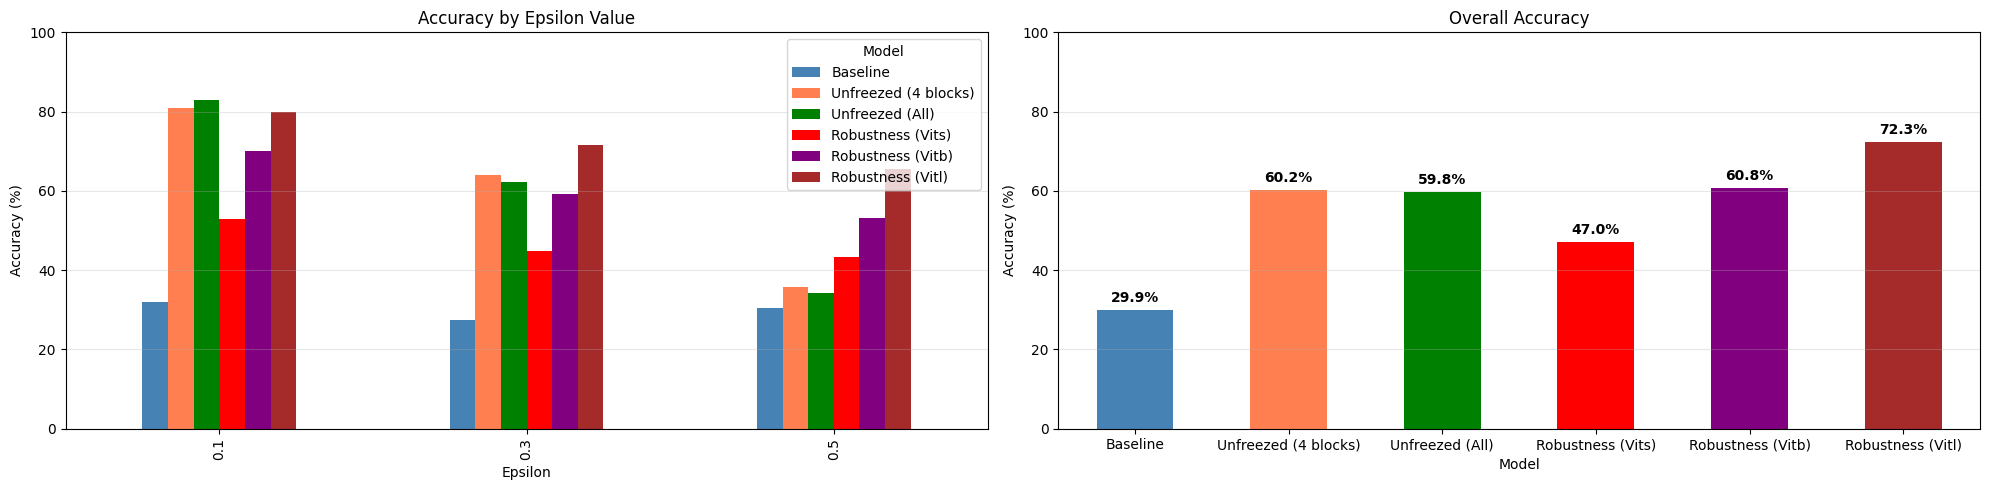

In [80]:
import matplotlib.pyplot as plt

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

order = ['baseline', 'adv_train_unfreeze_4', 'adv_train', 'robustness_token_vits', 'robustness_token_vitb', 'robustness_token_vitl']
new_cols = ['Baseline', 'Unfreezed (4 blocks)', 'Unfreezed (All)', 'Robustness (Vits)', 'Robustness (Vitb)', 'Robustness (Vitl)']

# Plot 1: Accuracy by epsilon
pivot = summary.reset_index().pivot(index='epsilon', columns='model', values='accuracy')
pivot = pivot[order]
pivot.columns = new_cols
pivot.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral', 'green', 'red', 'purple', 'brown'])
axes[0].set_title('Accuracy by Epsilon Value')
axes[0].set_xlabel('Epsilon')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim([0, 100])
axes[0].legend(title='Model')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Overall comparison
model_accs = all_results.groupby('model')['correct'].mean() * 100
model_accs = model_accs[order]
model_accs.index = new_cols
model_accs.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral', 'green', 'red', 'purple', 'brown'])
axes[1].set_title('Overall Accuracy')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim([0, 100])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(model_accs):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fgsm_eval_comparison.png', dpi=300)
plt.show()